In [1]:
from code_preprocessing.datasets import read_data

In [2]:
train_pd = read_data("train.csv")
train_pd.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThirdSsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
from code_preprocessing.selection_strategy import *


In [4]:

import pandas as pd
import os
import sys
import logging
from code_preprocessing.selection_strategy import *
from code_preprocessing.logging_utils import setup_default_logging
from code_preprocessing.preprocess import *
from code_preprocessing.cv_model import *
from code_preprocessing.datasets import read_data
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.pipeline import Pipeline
import numpy as np
def preprocess(train_pd):
    null_imputer = NullImputer()
    remove_imputer = RemovelColsImputer()
    imputer = Pipeline([('null_imputer', null_imputer)])
    return imputer.fit(train_pd)

def find_list_category_columns(X):
    uniq_count = X.nunique()
    category_crit = int(np.quantile(uniq_count, 0.75))
    is_category = (X.dtypes == "object") | (uniq_count <= category_crit)
    return is_category

def find_col_levels(X):
    col_levels = {}
    is_category = find_list_category_columns(X)
    for col in is_category.index:
        if is_category[col]:
            col_levels[col] = list(X[col].value_counts().index)
        else:
            col_levels[col] = []
    return col_levels

def select_features_step(train_pd, model_, strategy):
    select_tool = SelectionFeatures(model_)
    return select_tool.select_features(strategy)

def cv_process(list_cols_combine, model_):
    selected_cols = []
    for cols, model in list_cols_combine:
        cv_model = SMWrapper(model_, cols)
        cv = ShuffleSplit(n_splits=10, random_state=0)
        score = make_scorer(mean_squared_log_error, greater_is_better=False)
        cv_score = -np.mean(cross_val_score(cv_model, model_.data, model_.data[model_.target_col], cv=cv, scoring=score))
        logger.info(f"With {cols} - number_features = {len(cols)} - cv_score: {cv_score}")
        selected_cols.append((cols, model, cv_score))

    return min(selected_cols, key=lambda v : v[2])

def get_model(model_class, train_pd):
    predictor_cols = list(train_pd.columns[1: -1])
    target_col = train_pd.columns[-1]
    col_levels = find_col_levels(train_pd[predictor_cols])
    return model_class(train_pd, predictor_cols, target_col, col_levels)

In [5]:
selected_cols = ['Condition2']

In [6]:
from code_preprocessing.cv_model import *
from code_preprocessing.datasets import read_data
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_val_predict
from sklearn.metrics import mean_squared_log_error, make_scorer
imputer = preprocess(train_pd)
train_pd = imputer.transform(train_pd)
model_ = get_model(ModelOLSStats, train_pd)



In [7]:
model_.tss

9207911334609.977

In [8]:
result_fit2 = model_.fit(['Condition2', 'OverallQual'])

In [9]:
result_fit = model_.fit(selected_cols)

In [10]:
model_.cv_score(result_fit2)

3281289257699.208

In [11]:
train_pd['SalePrice'].iloc[1]

181500

In [14]:
from code_preprocessing.selection_strategy import MyAnova
table = MyAnova.anova_lm(model_, None, result_fit)
table

AttributeError: 'NoneType' object has no attribute 'cols'

In [15]:
anova_lm(result_fit, result_fit2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1452.0,9.116761e+12,0.0,NaN,NaN,NaN
1,1443.0,2.824574e+12,9.0,6.292187e+12,357.168017,0.0


In [12]:
cv_model = SMWrapper(model_, selected_cols)
cv = ShuffleSplit(n_splits=10, random_state=0)
score = make_scorer(mean_squared_log_error, greater_is_better=False)
cv_score = -np.mean(cross_val_score(cv_model, model_.data, model_.data[model_.target_col], cv=5, scoring=score))
cv_score

0.16567018053915822

In [15]:
cv_model = SMWrapper(model_, selected_cols)
cv = ShuffleSplit(n_splits=10, random_state=0)
score = make_scorer(mean_squared_log_error, greater_is_better=False)
y_pred = cross_val_predict(cv_model, model_.data, model_.data[model_.target_col], cv=2)

In [18]:
[i for i in range(0, 1460) if y_pred[i] < 0]

[825]

In [21]:
train_pd.loc[825][selected_cols]

OverallQual           10
Neighborhood     NridgHt
GrLivArea           2084
BsmtFinSF1          1636
OverallCond            5
YearBuilt           2007
MSSubClass            20
RoofMatl         CompShg
GarageCars             3
SaleCondition    Partial
LotArea            14803
Functional           Typ
KitchenQual           Ex
BsmtExposure          Av
TotalBsmtSF         2078
BsmtQual              Ex
Condition2          PosN
Condition1          PosN
ScreenPorch            0
FullBath               2
Exterior1st      CemntBd
LotConfig         Inside
Name: 825, dtype: object

In [30]:
train_pd.loc[825]['SalePrice']

385000

In [32]:
train_pd['SalePrice'].agg(['max', 'min'])

max    755000
min     34900
Name: SalePrice, dtype: int64

In [19]:
mean_squared_log_error(model_.data[model_.target_col], y_pred)

0.013211212552934618

In [6]:
cv_model.result_

AttributeError: 'SMWrapper' object has no attribute 'result_'

In [21]:
train_pd.iloc[0: 730]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,None,Reg,Lvl,Inside,Gtl,...,61,0,0,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,None,Reg,Lvl,FR2,Gtl,...,0,0,0,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,None,IR1,Lvl,Inside,Gtl,...,42,0,0,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,None,IR1,Lvl,Corner,Gtl,...,35,272,0,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,None,IR1,Lvl,FR2,Gtl,...,84,0,0,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,20,RL,60.000000,6960,None,Reg,Lvl,Inside,Gtl,...,0,0,0,None,500,11,2009,WD,Normal,120500
726,727,20,RL,70.049958,21695,None,IR1,Lvl,Corner,Gtl,...,44,0,0,None,0,12,2009,WD,Normal,222000
727,728,20,RL,64.000000,7314,None,Reg,Lvl,Inside,Gtl,...,0,0,0,None,0,2,2009,WD,Normal,194500
728,729,90,RL,85.000000,11475,None,Reg,Lvl,Corner,Gtl,...,25,0,0,None,0,7,2009,COD,Abnorml,110000


In [22]:
tmp_model = copy.deepcopy(model_)
tmp_model.data = model_.data.iloc[0: 730]
r = tmp_model.fit(selected_cols)
tmp_model.score(r)

SalePrice ~ C(OverallQual, levels=[5, 6, 7, 8, 4, 9, 3, 10, 2, 1])+C(Neighborhood, levels=['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'Gilbert', 'NridgHt', 'Sawyer', 'NWAmes', 'SawyerW', 'BrkSide', 'Crawfor', 'Mitchel', 'NoRidge', 'Timber', 'IDOTRR', 'ClearCr', 'StoneBr', 'SWISU', 'MeadowV', 'Blmngtn', 'BrDale', 'Veenker', 'NPkVill', 'Blueste'])+GrLivArea+BsmtFinSF1+C(OverallCond, levels=[5, 6, 7, 8, 4, 3, 9, 2, 1])+YearBuilt+C(MSSubClass, levels=[20, 60, 50, 120, 30, 160, 70, 80, 90, 190, 85, 75, 45, 180, 40])+C(RoofMatl, levels=['CompShg', 'Tar&Grv', 'WdShngl', 'WdShake', 'Metal', 'Roll', 'Membran', 'ClyTile'])+C(GarageCars, levels=[2, 1, 3, 0, 4])+C(SaleCondition, levels=['Normal', 'Partial', 'Abnorml', 'Family', 'Alloca', 'AdjLand'])+LotArea+C(Functional, levels=['Typ', 'Min2', 'Min1', 'Mod', 'Maj1', 'Maj2', 'Sev'])+C(KitchenQual, levels=['TA', 'Gd', 'Ex', 'Fa'])+C(BsmtExposure, levels=['No', 'Av', 'Gd', 'Mn', 'None'])+TotalBsmtSF+C(BsmtQual, levels=['TA', 'Gd', 'Ex', 'No

0.012472853458854842

In [24]:
r.params

Intercept                                                     -717388.242318
C(OverallQual, levels=[5, 6, 7, 8, 4, 9, 3, 10, 2, 1])[T.6]      4863.539049
C(OverallQual, levels=[5, 6, 7, 8, 4, 9, 3, 10, 2, 1])[T.7]     13007.455651
C(OverallQual, levels=[5, 6, 7, 8, 4, 9, 3, 10, 2, 1])[T.8]     32556.194226
C(OverallQual, levels=[5, 6, 7, 8, 4, 9, 3, 10, 2, 1])[T.4]      -965.917762
                                                                   ...      
BsmtFinSF1                                                         21.117075
YearBuilt                                                         378.385859
LotArea                                                             0.422210
TotalBsmtSF                                                        15.983898
ScreenPorch                                                        32.803267
Length: 131, dtype: float64

In [41]:
from patsy.contrasts import Treatment
contrast = Treatment(reference=0)

In [7]:
formula = "SalePrice ~ C(OverallQual, levels=[5, 6, 7, 8, 4, 9, 3, 10, 2, 1])+C(Neighborhood, levels=['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'Gilbert', 'NridgHt', 'Sawyer', 'NWAmes', 'SawyerW', 'BrkSide', 'Crawfor', 'Mitchel', 'NoRidge', 'Timber', 'IDOTRR', 'ClearCr', 'StoneBr', 'SWISU', 'MeadowV', 'Blmngtn', 'BrDale', 'Veenker', 'NPkVill', 'Blueste'])+GrLivArea+BsmtFinSF1+C(OverallCond, levels=[5, 6, 7, 8, 4, 3, 9, 2, 1])+YearBuilt+C(MSSubClass, levels=[20, 60, 50, 120, 30, 160, 70, 80, 90, 190, 85, 75, 45, 180, 40])+C(RoofMatl, levels=['CompShg', 'Tar&Grv', 'WdShngl', 'WdShake', 'Metal', 'Roll', 'Membran', 'ClyTile'])+C(GarageCars, levels=[2, 1, 3, 0, 4])+C(SaleCondition, levels=['Normal', 'Partial', 'Abnorml', 'Family', 'Alloca', 'AdjLand'])+LotArea+C(Functional, levels=['Typ', 'Min2', 'Min1', 'Mod', 'Maj1', 'Maj2', 'Sev'])+C(KitchenQual, levels=['TA', 'Gd', 'Ex', 'Fa'])+C(BsmtExposure, levels=['No', 'Av', 'Gd', 'Mn', 'None'])+TotalBsmtSF+C(BsmtQual, levels=['TA', 'Gd', 'Ex', 'None', 'Fa'])+C(Condition2, levels=['Norm', 'Feedr', 'RRNn', 'PosN', 'Artery', 'RRAn', 'PosA', 'RRAe'])+C(Condition1, levels=['Norm', 'Feedr', 'Artery', 'RRAn', 'PosN', 'RRAe', 'PosA', 'RRNn', 'RRNe'])+ScreenPorch+C(FullBath, levels=[2, 1, 3, 0])+C(Exterior1st, levels=['VinylSd', 'HdBoard', 'MetalSd', 'Wd Sdng', 'Plywood', 'CemntBd', 'BrkFace', 'WdShing', 'Stucco', 'AsbShng', 'Stone', 'BrkComm', 'ImStucc', 'CBlock', 'AsphShn'])+C(LotConfig, levels=['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'])"

In [30]:
import patsy
x = patsy.dmatrices(formula, train_pd.iloc[[825]][selected_cols + ['SalePrice']], return_type="dataframe")[1]

In [33]:
x.iloc[0]

Intercept                                                          1.0
C(OverallQual, levels=[5, 6, 7, 8, 4, 9, 3, 10, 2, 1])[T.6]        0.0
C(OverallQual, levels=[5, 6, 7, 8, 4, 9, 3, 10, 2, 1])[T.7]        0.0
C(OverallQual, levels=[5, 6, 7, 8, 4, 9, 3, 10, 2, 1])[T.8]        0.0
C(OverallQual, levels=[5, 6, 7, 8, 4, 9, 3, 10, 2, 1])[T.4]        0.0
                                                                ...   
BsmtFinSF1                                                      1636.0
YearBuilt                                                       2007.0
LotArea                                                        14803.0
TotalBsmtSF                                                     2078.0
ScreenPorch                                                        0.0
Name: 825, Length: 131, dtype: float64

In [49]:
tmp = pd.concat([x.iloc[0], r.params], axis = 1)[825] * pd.concat([x.iloc[0], r.params], axis = 1)[0]

In [50]:
tmp[tmp < 0]

Intercept                                                                                                                                                                                             -717388.242318
C(Condition2, levels=['Norm', 'Feedr', 'RRNn', 'PosN', 'Artery', 'RRAn', 'PosA', 'RRAe'])[T.PosN]                                                                                                     -454378.895785
C(Exterior1st, levels=['VinylSd', 'HdBoard', 'MetalSd', 'Wd Sdng', 'Plywood', 'CemntBd', 'BrkFace', 'WdShing', 'Stucco', 'AsbShng', 'Stone', 'BrkComm', 'ImStucc', 'CBlock', 'AsphShn'])[T.CemntBd]     -1348.857502
dtype: float64

In [56]:
train_pd[train_pd['Condition2'] == "PosN"]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,None,IR1,Bnk,Inside,Gtl,...,406,0,0,None,0,10,2007,New,Partial,184750
825,826,20,RL,114.0,14803,None,Reg,Lvl,Inside,Gtl,...,45,0,0,None,0,6,2008,New,Partial,385000


In [61]:
len(train_pd)

1460

In [60]:
rank_cols = RankColumns()
rank_cols.cal_fpvalue_special_col(train_pd, 'Condition2')

0.03774804420194121

In [36]:
r.predict(train_pd.iloc[[825]])

825   -4026.423822
dtype: float64

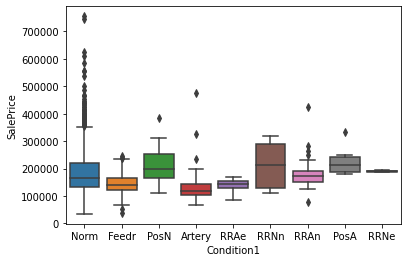

In [58]:
import seaborn as sns
sns.boxplot(x='Condition1', y='SalePrice', data=train_pd)

In [59]:
train_pd['Condition1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [12]:
from statsmodels.formula.api import ols
model = ols('SalePrice~C(OverallQual)', data=train_pd).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     349.0
Date:                Wed, 01 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:31:19   Log-Likelihood:                -17703.
No. Observations:                1460   AIC:                         3.543e+04
Df Residuals:                    1450   BIC:                         3.548e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             5.015e+04   3.17e+04      1.584      0.113    -1.2e+04    1.12e+05
C(OverallQual)[T.2]   1620.3333   4.09e+04      0.040      0.968   -7.86e+04    8.18e+04
C(OverallQual)[T.3]   3.732e+04   3.32e+04      1.124      0.261   -2.78e+04    1.02e+05
C(OverallQual)[T.4]   5.827e+04   3.19e+04      1.824      0.068   -4379.660    1.21e+05
C(OverallQual)[T.5]   8.337e+04   3.17e+04      2.626      0.009    2.11e+04    1.46e+05
C(OverallQual)[T.6]   1.115e+05   3.18e+04      3.510      0.000    4.92e+04    1.74e+05
C(OverallQual)[T.7]   1.576e+05   3.18e+04      4.960      0.000    9.53e+04     2.2e+05
C(OverallQual)[T.8]   2.246e+05   3.19e+04      7.050      0.000    1.62e+05    2.87e+05
C(OverallQual)[T.9]   3.174e+05   3.24e+04      9.797      0.000    2.54e+05    3.81e+05
C(OverallQual)[T.10]  3.884e+05   3.34e+04     11.637      0.000    3.23e+05    4.54e+05
==============================================================================
Omnibus:                      377.831   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3528.673
Skew:                           0.929   Prob(JB):                         0.00
Kurtosis:                      10.386   Cond. No.                         94.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
import math
math.sqrt(model.ssr)

1705294.9036644984

In [21]:
model2 = ols('SalePrice~OverallQual^2 + OverallQual', data=train_pd).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1314.
Date:                Wed, 01 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:37:43   Log-Likelihood:                -17791.
No. Observations:                1460   AIC:                         3.559e+04
Df Residuals:                    1457   BIC:                         3.560e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.079e+05   5785.548    -18.644      0.000   -1.19e+05   -9.65e+04
OverallQual ^ 2  5445.6040    640.604      8.501      0.000    4188.999    6702.209
OverallQual      4.191e+04    989.761     42.345      0.000       4e+04    4.39e+04
==============================================================================
Omnibus:                      609.200   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6586.745
Skew:                           1.639   Prob(JB):                         0.00
Kurtosis:                      12.876   Cond. No.                         41.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
train_pd['PoolArea'].value_counts()[0] / train_pd.rows

AttributeError: 'DataFrame' object has no attribute 'rows'

In [14]:
train_pd[1:-1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1455,20,FV,62.0,7500,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,185000
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [5]:
train_pd.sample(frac=1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
200,201,20,RM,80.0,8546,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,140000
229,230,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,192500
1042,1043,120,RL,34.0,5381,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,196000
1434,1435,20,RL,80.0,17400,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,160000
873,874,40,RL,60.0,12144,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Othr,0,9,2009,WD,Normal,133000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,742,20,RL,65.0,6768,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,5,2008,WD,Normal,142000
163,164,45,RL,55.0,5500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,4,2007,WD,Normal,103200
206,207,20,RL,40.0,13673,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,143900
793,794,20,RL,76.0,9158,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,New,Partial,225000


In [4]:
null_cols = train_pd.isnull().sum()[train_pd.isnull().sum() > 0]
null_cols.index
train_pd[list(null_cols.index)].dtypes

LotFrontage     float64
Alley            object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
MiscFeature      object
dtype: object

In [5]:
t = train_pd.isnull().sum() / train_pd.shape[0]
t[t > 0]

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

In [18]:
a = pd.DataFrame([['a', 'b', 2], ['c', 'd', 5], ['e', 'f', 4]], columns = ['col1', 'col2', 'tar'])

In [19]:
a

,col1,col2,tar
0,a,b,2
1,c,d,5
2,e,f,4


In [21]:
from statsmodels.formula.api import ols
levels = {}
levels['col1'] = ['a', 'c', 'e']
levels['col2'] = ['b', 'd', 'f']
model = ols('tar ~ C(col1, levels = levels["col1"]) + C(col2, levels = levels["col2"])', a).fit

NameError: name 'levels' is not defined

In [6]:
train_pd['GarageCond'].value_counts()

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [23]:
train_pd.shape

(1460, 81)

In [8]:
train_pd['OverallQual'].value_counts().iloc[0]

397

In [4]:
from code_preprocessing.preprocess import NullImputer, RemovelColsImputer
data_imputer = NullImputer()
remove_imputer = RemovelColsImputer()
df = data_imputer.fit_transform(train_pd)

In [5]:
df = remove_imputer.fit_transform(df)

Street   inf
Utilities   inf
Condition2   0.03774804420194121
RoofMatl   0.07954330129064048
Heating   0.02435659124979038
LowQualFinSF   0.0004156670475828552
KitchenAbvGr   0.6284501943504774
ThirdSsnPorch   0.21881621596739814
PoolArea   nan
PoolQC   0.30398528011207915
MiscFeature   0.10472761568792871
MiscVal   0.03098283473159248


In [4]:
df.shape

(1460, 81)

In [6]:
remove_imputer.remove_categorys

['Street',
 'Utilities',
 'KitchenAbvGr',
 'ThirdSsnPorch',
 'PoolArea',
 'PoolQC',
 'MiscFeature']

In [4]:
data_imputer.remove_cols

['Street',
 'Utilities',
 'RoofMatl',
 'LowQualFinSF',
 'KitchenAbvGr',
 'ThirdSsnPorch',
 'PoolArea']

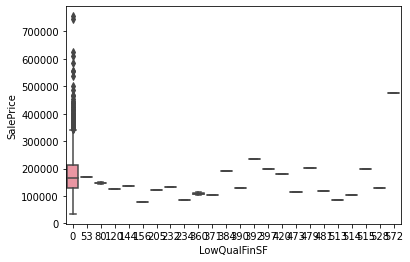

In [18]:
import seaborn as sns
sns.boxplot(x = 'LowQualFinSF', y = 'SalePrice', data=train_pd)
#train_pd.groupby('Street')['SalePrice'].mean()

In [20]:
train_pd['LowQualFinSF'].nunique()

24

In [51]:
train_pd.groupby('Condition2').agg({"SalePrice": ["mean", "count", "max", "min"]})

SalePrice                      
                     mean count     max     min
Condition2                                     
Artery      106500.000000     2  118000   95000
Feedr       121166.666667     6  167500   79500
Norm        181169.405536  1445  755000   34900
PosA        325000.000000     1  325000  325000
PosN        284875.000000     2  385000  184750
RRAe        190000.000000     1  190000  190000
RRAn        136905.000000     1  136905  136905
RRNn         96750.000000     2  125000   68500

In [14]:
from statsmodels.formula.api import ols
def getOLS(data, predictor):
    result = ols(f"SalePrice ~ C({predictor})", data=data).fit()
    return result

In [47]:
new_train_pd = train_pd[train_pd['Condition2'] != "Norm"]

In [48]:
result = getOLS(new_train_pd, 'Condition2')

In [15]:
def cal_fpvalue_special_col(col_name):
    if train_pd[col_name].nunique() == 2:
        return float('inf')
    mode = train_pd[col_name].value_counts().index[0]
    new_train_pd = train_pd[train_pd[col_name] != mode]
    print(new_train_pd.shape)
    result_ols = getOLS(new_train_pd, col_name)
    return result_ols.f_pvalue


In [17]:
import pandas as pd
pd.Series([cal_fpvalue_special_col(col) for col in data_imputer.remove_cols], index = data_imputer.remove_cols)

(26, 81)
(26, 81)
(68, 81)
(24, 81)
(7, 81)


Street                inf
Utilities             inf
RoofMatl         0.079543
LowQualFinSF     0.000416
KitchenAbvGr     0.628450
ThirdSsnPorch    0.218816
PoolArea              NaN
dtype: float64

In [6]:
df['Alley'].value_counts()

None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

In [ ]:
df[]

In [8]:
train_pd['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [8]:
train_pd.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [9]:
train_pd

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [10]:
pd.set_option('display.max_columns', 70)
pd.DataFrame(train_pd.nunique()).transpose()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,...,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1460,15,5,110,1073,2,2,4,4,2,5,3,25,9,8,5,8,10,9,112,61,6,8,15,16,4,327,4,5,6,4,4,4,6,637,...,861,4,3,4,3,8,4,4,12,7,4,5,6,97,3,5,441,5,5,3,274,202,120,20,76,8,3,4,4,21,12,5,9,6,663


In [11]:
train_pd = train_pd.rename(columns = {"3SsnPorch": "ThreeeSsnPorch"})
train_pd.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [12]:
dtypes = train_pd.dtypes
dtypes[dtypes == "float64"]

LotFrontage    float64
MasVnrArea     float64
GarageYrBlt    float64
dtype: object

In [13]:
dtypes['SalePrice']

dtype('int64')

In [14]:
train_pd[["MSSubClass", "SalePrice"]].groupby("MSSubClass")["SalePrice"].mean()

MSSubClass
20     185224.811567
30      95829.724638
40     156125.000000
45     108591.666667
50     143302.972222
60     239948.501672
70     166772.416667
75     192437.500000
80     169736.551724
85     147810.000000
90     133541.076923
120    200779.080460
160    138647.380952
180    102300.000000
190    129613.333333
Name: SalePrice, dtype: float64

In [15]:
import researchpy as rp
rp.summary_cont(train_pd['SalePrice'].groupby(train_pd['MSSubClass']))


,N,Mean,SD,SE,95% Conf.,Interval
MSSubClass,,,,,,
20,536,185224.811567,78782.189967,3402.872321,178548.951430,191900.671704
30,69,95829.724638,24857.110083,2992.444403,89921.564602,101737.884674
40,4,156125.000000,75747.799748,37873.899874,70408.295353,241841.704647
45,12,108591.666667,20231.723889,5840.395617,96635.481892,120547.851441
50,144,143302.972222,54851.983707,4570.998642,134312.543733,152293.400711
60,299,239948.501672,86579.909966,5007.045474,230118.240211,249778.763134
70,60,166772.416667,58206.545762,7514.432746,151919.836930,181624.996404
75,16,192437.500000,100556.762577,25139.190644,141548.756870,243326.243130
80,58,169736.551724,38197.808771,5015.618013,159820.081922,179653.021527


In [9]:
from statsmodels.formula.api import ols
results = ols('SalePrice ~ C(Alley)', data = train_pd).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     35.56
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           4.90e-08
Time:                        17:16:32   Log-Likelihood:                -1083.9
No. Observations:                  91   AIC:                             2172.
Df Residuals:                      89   BIC:                             2177.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.222e+05   5153.091     23.718      0.000    1.12e+05    1.32e+05
C(Alley)[T.Pave]  4.578e+04   7677.090      5.963      0.000    3.05e+04     6.1e+04
==============================================================================
Omnibus:                       10.670   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               28.438
Skew:                           0.102   Prob(JB):                     6.68e-07
Kurtosis:                       5.731   Cond. No.                         2.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
result2 = ols('SalePrice ~ C(Alley)', data = df).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     15.18
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           3.00e-07
Time:                        17:21:48   Log-Likelihood:                -18529.
No. Observations:                1460   AIC:                         3.706e+04
Df Residuals:                    1457   BIC:                         3.708e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.222e+05   1.11e+04     10.984      0.000       1e+05    1.44e+05
C(Alley)[T.None]  6.123e+04   1.13e+04      5.405      0.000     3.9e+04    8.35e+04
C(Alley)[T.Pave]  4.578e+04   1.66e+04      2.762      0.006    1.33e+04    7.83e+04
==============================================================================
Omnibus:                      612.504   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3535.316
Skew:                           1.877   Prob(JB):                         0.00
Kurtosis:                       9.635   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
results.mse_total

1837591464.014408

In [14]:
result2.mse_total

6311111264.297448

In [34]:
for col, pvalue in enumerate(results.pvalues):
    print(col, pvalue)

0 0.0
1 3.6600385734929035e-23
2 0.40290538820860566
3 0.00015783294125191346
4 1.5735063986404618e-10
5 8.107245407334332e-27
6 0.0506695483387308
7 0.6816971451342002
8 0.10613313853835632
9 0.017888786857600335
10 3.212366722497661e-07
11 0.05235447929125894
12 5.076095069002471e-07
13 0.0001844574740300455
14 2.0169903488927322e-05


In [17]:
import math
import numpy as np
np.std(results.resid)

68944.36756976064

In [36]:
uniq_count = train_pd.nunique()
uniq_count.describe()

count      81.000000
mean      120.395062
std       275.344769
min         2.000000
25%         4.000000
50%         6.000000
75%        25.000000
max      1460.000000
dtype: float64

In [19]:
import numpy
numpy.quantile(uniq_count, 0.75)

25.0

In [29]:
(uniq_count <= 25)['LotArea']

False

In [20]:
category_cols = uniq_count[uniq_count <= 25].index
category_cols

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', 'ThreeeSsnPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [21]:
selected_cols = []
for col_name in category_cols:
    model_result = ols(f'SalePrice ~ C({col_name})', data = train_pd).fit()
    if model_result.f_pvalue < 0.05:
        selected_cols.append(col_name)

In [22]:
selected_cols

['MSSubClass',
 'MSZoning',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolArea',
 'Fence',
 'SaleType',
 'SaleCondition']

In [7]:
test_model = ols('SalePrice ~ C(Alley)', data = train_pd).fit()
test_model.summary()

NameError: name 'ols' is not defined

In [22]:
test_model = ols('SalePrice ~ C(MSSubClass) + C(MSZoning)', data = train_pd).fit()
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     29.74
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           8.06e-86
Time:                        17:29:37   Log-Likelihood:                -18313.
No. Observations:                1460   AIC:                         3.666e+04
Df Residuals:                    1441   BIC:                         3.677e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.044e+05    2.2e+04      4.736      0.000    6.11e+04    1.48e+05
C(MSSubClass)[T.30]  -7.155e+04   9211.016     -7.768      0.000   -8.96e+04   -5.35e+04
C(MSSubClass)[T.40]  -1.339e+04   3.44e+04     -0.390      0.697   -8.08e+04    5.41e+04
C(MSSubClass)[T.45]  -5.542e+04   2.03e+04     -2.731      0.006   -9.52e+04   -1.56e+04
C(MSSubClass)[T.50]  -2.848e+04   6763.228     -4.212      0.000   -4.18e+04   -1.52e+04
C(MSSubClass)[T.60]   5.259e+04   4959.018     10.606      0.000    4.29e+04    6.23e+04
C(MSSubClass)[T.70]  -1895.7470   9695.608     -0.196      0.845   -2.09e+04    1.71e+04
C(MSSubClass)[T.75]   2.701e+04   1.77e+04      1.525      0.127   -7729.916    6.17e+04
C(MSSubClass)[T.80]  -1.612e+04   9440.180     -1.708      0.088   -3.46e+04    2393.914
C(MSSubClass)[T.85]  -3.805e+04   1.55e+04     -2.447      0.015   -6.85e+04   -7551.221
C(MSSubClass)[T.90]  -4.662e+04   9979.338     -4.672      0.000   -6.62e+04    -2.7e+04
C(MSSubClass)[T.120]  2.247e+04   8032.538      2.798      0.005    6717.461    3.82e+04
C(MSSubClass)[T.160] -3.834e+04   1.01e+04     -3.792      0.000   -5.82e+04   -1.85e+04
C(MSSubClass)[T.180] -5.087e+04   2.26e+04     -2.251      0.025   -9.52e+04   -6540.667
C(MSSubClass)[T.190] -3.932e+04   1.31e+04     -3.008      0.003    -6.5e+04   -1.37e+04
C(MSZoning)[T.FV]     1.007e+05   2.37e+04      4.248      0.000    5.42e+04    1.47e+05
C(MSZoning)[T.RH]     4.812e+04   2.77e+04      1.736      0.083   -6257.521    1.03e+05
C(MSZoning)[T.RL]     8.151e+04   2.19e+04      3.716      0.000    3.85e+04    1.25e+05
C(MSZoning)[T.RM]     4.882e+04   2.22e+04      2.197      0.028    5234.574    9.24e+04
==============================================================================
Omnibus:                      748.920   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6081.850
Skew:                           2.255   Prob(JB):                         0.00
Kurtosis:                      11.923   Cond. No.                         36.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
test_model.mse_total

6311111264.297448

In [25]:
test_model2 = ols('SalePrice ~ C(MSSubClass) + C(Alley)', data = train_pd).fit()
test_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     15.18
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           3.00e-07
Time:                        17:36:55   Log-Likelihood:                -18529.
No. Observations:                1460   AIC:                         3.706e+04
Df Residuals:                    1457   BIC:                         3.708e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.222e+05   1.11e+04     10.984      0.000       1e+05    1.44e+05
C(Alley)[T.None]  6.123e+04   1.13e+04      5.405      0.000     3.9e+04    8.35e+04
C(Alley)[T.Pave]  4.578e+04   1.66e+04      2.762      0.006    1.33e+04    7.83e+04
==============================================================================
Omnibus:                      612.504   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3535.316
Skew:                           1.877   Prob(JB):                         0.00
Kurtosis:                       9.635   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
test_model2.mse_total

6311111264.297448

In [25]:
np.std(test_model.resid)

27585.483275515056

In [39]:
train_pd.columns[1:]

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [53]:
from mix_selection import *
predictor_cols = train_pd.columns[1: -1]
target_col = train_pd.columns[-1]
select_tool = SelectionFeatures(ModelOLSStats)

In [ ]:
'OverallQual', 'GrLivArea', 'Neighborhood', 'PoolArea'

In [3]:
from code_preprocessing.preprocess import *
imputer = DataFrameImputer()
imputer = imputer.fit(train_pd)

TypeError: 'method' object is not subscriptable

In [13]:
imputer.is_category[['OverallQual','GrLivArea', 'Neighborhood', 'PoolArea']]

OverallQual      True
GrLivArea       False
Neighborhood     True
PoolArea         True
dtype: bool

In [66]:
from statsmodels.formula.api import ols
model1 = ols('SalePrice ~ GrLivArea', data = train_pd).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1471.
Date:                Sat, 28 Mar 2020   Prob (F-statistic):          4.52e-223
Time:                        15:51:02   Log-Likelihood:                -18035.
No. Observations:                1460   AIC:                         3.607e+04
Df Residuals:                    1458   BIC:                         3.608e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.857e+04   4480.755      4.144      0.000    9779.612    2.74e+04
GrLivArea    107.1304      2.794     38.348      0.000     101.650     112.610
==============================================================================
Omnibus:                      261.166   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3432.287
Skew:                           0.410   Prob(JB):                         0.00
Kurtosis:                      10.467   Cond. No.                     4.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
import math
math.sqrt(model1.ssr/model1.nobs)

56034.303865279944

In [68]:
model1.resid

0        6738.060312
1       27732.461129
2       13596.153031
3      -62511.852201
4       -4041.554863
            ...     
1455   -20012.727073
1456   -30650.259993
1457    -2754.065837
1458     8069.447178
1459    -5624.756718
Length: 1460, dtype: float64

In [98]:
predict1 = model1.predict(train_pd.iloc[[197, 810, 1170, 1182, 1298, 1386, 1423]]).rename('predict1')
predict2 = model2.predict(train_pd.iloc[[197, 810, 1170, 1182, 1298, 1386, 1423]]).rename('predict2')

In [103]:
pool = train_pd.iloc[[197, 810, 1170, 1182, 1298, 1386, 1423]]['PoolArea']
real = train_pd.iloc[[197, 810, 1170, 1182, 1298, 1386, 1423]]['SalePrice']


In [108]:
pd.concat([pool, real, predict1, predict2, predict2- predict1], axis=1)

,PoolArea,SalePrice,predict1,predict2,0
197,512,235000,351958.702958,235000.0,-116958.702958
810,648,181000,158802.665743,181000.0,22197.334257
1170,576,171000,138340.767180,171000.0,32659.232820
1182,555,745000,498084.512588,745000.0,246915.487413
1298,480,160000,622998.511142,160000.0,-462998.511142
1386,519,250000,316819.945217,250000.0,-66819.945217
1423,738,274970,254362.945940,274970.0,20607.054060


In [102]:
model2.params

Intercept              12887.682309
C(PoolArea)[T.480]   -479400.358769
C(PoolArea)[T.512]   -123457.949793
C(PoolArea)[T.519]    -72035.376614
C(PoolArea)[T.555]    235077.447107
C(PoolArea)[T.576]     33964.644475
C(PoolArea)[T.648]     22755.158264
C(PoolArea)[T.738]     17673.526324
GrLivArea                111.044430
dtype: float64

In [70]:
from statsmodels.formula.api import ols
model2 = ols('SalePrice ~ GrLivArea + C(PoolArea)', data = train_pd).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     208.6
Date:                Sat, 28 Mar 2020   Prob (F-statistic):          6.65e-235
Time:                        15:51:55   Log-Likelihood:                -17985.
No. Observations:                1460   AIC:                         3.599e+04
Df Residuals:                    1451   BIC:                         3.604e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.289e+04   4481.074      2.876      0.004    4097.607    2.17e+04
C(PoolArea)[T.480] -4.794e+05   5.56e+04     -8.625      0.000   -5.88e+05    -3.7e+05
C(PoolArea)[T.512] -1.235e+05   5.45e+04     -2.264      0.024    -2.3e+05   -1.65e+04
C(PoolArea)[T.519] -7.204e+04   5.45e+04     -1.323      0.186   -1.79e+05    3.48e+04
C(PoolArea)[T.555]  2.351e+05    5.5e+04      4.275      0.000    1.27e+05    3.43e+05
C(PoolArea)[T.576]  3.396e+04   5.44e+04      0.625      0.532   -7.27e+04    1.41e+05
C(PoolArea)[T.648]  2.276e+04   5.44e+04      0.419      0.676   -8.39e+04    1.29e+05
C(PoolArea)[T.738]  1.767e+04   5.44e+04      0.325      0.745    -8.9e+04    1.24e+05
GrLivArea            111.0444      2.816     39.431      0.000     105.520     116.569
==============================================================================
Omnibus:                      263.098   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1597.258
Skew:                           0.691   Prob(JB):                         0.00
Kurtosis:                       7.934   Cond. No.                     6.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
math.sqrt(model2.ssr /model2.nobs)

54161.94468074101

In [73]:
from statsmodels.stats.api import anova_lm
anova_table = anova_lm(model1, model2)
anova_table["Pr(>F)"][1]

1.913048513254655e-18

In [39]:
import pandas as pd
tmp = pd.concat([model1.resid, model2.resid, model1.resid - model2.resid], axis=1)
tmp[[2]].describe()

,2
count,1.460000e+03
mean,5.220799e-09
std,1.146555e+04
min,-3.580553e+05
25%,-1.227259e+03
50%,-1.233824e+02
75%,1.182271e+03
max,2.021839e+05


In [43]:
tmp[tmp[2] >= 2.021839e+05]

,0,1,2
1182,202183.948516,-4.051253e-08,202183.948516


In [46]:
model2.resid[abs(model2.resid) <= 1]

197    -2.997695e-08
810    -1.056469e-08
1170   -6.606570e-09
1182   -4.051253e-08
1298   -5.506445e-08
1386   -2.485467e-08
1423   -1.996523e-08
dtype: float64

In [50]:
train_pd[['PoolArea']].iloc[[197, 810, 1170, 1182, 1298, 1386, 1423]]

,PoolArea
197,512
810,648
1170,576
1182,555
1298,480
1386,519
1423,738


In [41]:
train_pd[['GrLivArea']].describe()

,GrLivArea
count,1460.000000
mean,1515.463699
std,525.480383
min,334.000000
25%,1129.500000
50%,1464.000000
75%,1776.750000
max,5642.000000


In [ ]:
predictor_cols = ['GrLivArea']
target_col = 'SalePrice'

cv_model = SMWrapper(ModelOLSStats, predictor_cols, target_col, cols, col_levels)
cv = ShuffleSplit(n_splits=10, random_state=0)
cv_score = -np.mean(cross_val_score(cv_model, train_pd, train_pd[target_col], cv=cv, scoring="neg_mean_squared_error"))
logger.info(f"With {cols} - number_features = {len(cols)} - cv_score: {cv_score}")